In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.models as models
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
import torchvision.transforms.functional as TF
import cv2
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter
import numpy as np


In [76]:
class MaxPool(nn.Module):
    def __init__(self, pool_size):
        super(MaxPool, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=pool_size, stride=pool_size)

    def forward(self, x):
        return self.pool(x)


class Noise(nn.Module):
    def __init__(self, R_scale):
        super(Noise, self).__init__()
        self.mean = 0
        self.stdev = 1  # as defined in the paper

    def forward(self, d_coarse):
        noise = torch.rand_like(d_coarse)*self.stdev + self.mean
        d_noised = d_coarse + noise
        return d_noised


class IntervalThreshold(nn.Module):
    def __init__(self, m, n):
        super(IntervalThreshold, self).__init__()
        self.m = m
        self.n = n

    def forward(self, d_pool):
        threshold = (torch.max(d_pool) - torch.min(d_pool))/min(self.m, self.n)
        return threshold


class ReconGraph(nn.Module):
    def __init__(self, m, n):
        super(ReconGraph, self).__init__()
        self.m = m
        self.n = n

    def forward(self, d_noised, threshold):
        neighbours = set()
        labels = {}

        count = 0
        print(self.m, self.n)
        for i in range(self.m):
            for j in range(self.n):

                labels[(j, i)] = count  # Labeling each pixel in (x, y) form
                count += 1
                for dy in range(-1, 2):
                    for dx in range(-1, 2):

                        if dx != 0 and dy != 0 and i+dy >= 0 and i+dy < self.m and j+dx >= 0 and j+dx < self.n:
                            if abs(d_noised[0][0][i+dy][j+dx] - d_noised[0][0][i][j]) <= threshold:
                                # (x, y) format
                                neighbours.add(((j, i), (j+dx, i+dy)))
        adjacency_matrix = torch.zeros(
            (self.m*self.n, self.m*self.n), dtype=bool)
        print(adjacency_matrix.shape)

        for val in neighbours:
            N1, N2 = val  # in (x, y) form
            N1_x, N1_y = N1
            N2_x, N2_y = N2

            l1 = labels[(N1_x, N1_y)]
            l2 = labels[(N2_x, N2_y)]

            # Symmetric connections
            adjacency_matrix[l1, l2] = 1
            adjacency_matrix[l2, l1] = 1

        return adjacency_matrix


class GraphDropout(nn.Module):
    def __init__(self, p=0.5) -> None:
        super(GraphDropout, self).__init__()
        self.p = p

    def forward(self, adjacency_matrix):
        if self.train:
            mask = torch.empty_like(adjacency_matrix).bernoulli_(1 - self.p)
            output = adjacency_matrix * mask

        else:
            output = adjacency_matrix

        return output

In [82]:
class ExtractGraph(nn.Module):

    def __init__(self) -> None:
        super(ExtractGraph, self).__init__()

        self.maxpool = MaxPool(pool_size=2)
        self.noise = Noise(R_scale=0.4)  # From paper results
        self.dropout = GraphDropout(p=0.5)

    def forward(self, d_coarse, R_scale):

        d_pool = self.maxpool.forward(d_coarse)
        m = d_pool.shape[2]
        n = d_pool.shape[3]
        self.interval_threshold = IntervalThreshold(m, n)
        self.recon_graph = ReconGraph(m, n)

        print("pooled shape ", d_pool.shape)
        d_noise = self.noise.forward(d_pool)
        threshold = self.interval_threshold.forward(d_pool)
        adjacency_matrix = self.recon_graph.forward(d_noise, threshold)
        adjacency_matrix = self.dropout.forward(adjacency_matrix)

        return adjacency_matrix

In [3]:
class Encoder(nn.Module):

    def __init__(self) -> None:
        super(Encoder, self).__init__()
        encoder = models.resnet.resnet50(
            weights=models.ResNet50_Weights.DEFAULT)
        encoder = nn.Sequential(*list(encoder.children()))[:4]
        self.resnet_encoder = encoder

    def forward(self, x):
        self.resnet_encoder.eval()
        return self.resnet_encoder(x)


In [4]:
class GNNModel(nn.Module):

    def __init__(self, n_features) -> None:
        super(GNNModel, self).__init__()
        self.gcn1 = pyg_nn.GCNConv(n_features, 128)
        self.gcn2 = pyg_nn.GCNConv(128, 256)
        self.gcn3 = pyg_nn.GCNConv(256, 32)
        self.gcn4 = pyg_nn.GCNConv(32, 1)

    def forward(self, x, edge_index):
        x = F.relu(self.gcn1(x, edge_index))
        x = F.relu(self.gcn2(x, edge_index))
        x = F.relu(self.gcn3(x, edge_index))
        x = F.relu(self.gcn4(x, edge_index))

        return x


In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [6]:
from torchvision.transforms import transforms
from PIL import Image

preprocessing_transform = transforms.Compose([
    transforms.Resize((240, 320), interpolation=Image.Resampling.BILINEAR),
    transforms.CenterCrop((228, 304)),
    transforms.ToTensor()
])

preprocessing_transform_2 = transforms.Compose([
    transforms.ToTensor()
])

/Users/adityadandwate/opt/anaconda3/envs/pytorch/lib/python3.10/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [86]:
from gcn_depth_dataloader import GCNDepthDataLoader
from torch.utils.data import DataLoader

# for train set
nyu_dataset_train = GCNDepthDataLoader(mode='train', 
                                image_folder='../dataset/dataset/nyu_depth_v2/official_splits/train/rgb',
                                depth_folder='../dataset/dataset/nyu_depth_v2/official_splits/train/depth',
                                transform=preprocessing_transform_2)

nyu_dataset_train.__len__()

train_dataloader = DataLoader(nyu_dataset_train, batch_size=8, shuffle=True)
len(train_dataloader)

100

torch.Size([8, 3, 480, 640]) torch.Size([8, 1, 480, 640])
grid shape rgb  torch.Size([3, 484, 5138])
(484, 5138, 3)


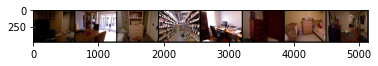

In [8]:
from torchvision.utils import make_grid

batch = next(iter(train_dataloader))
rgb, depth = batch

print(rgb.shape, depth.shape)

rgb_grid = make_grid(rgb)
print('grid shape rgb ', rgb_grid.shape)
rgb_grid = rgb_grid.numpy().transpose((1, 2, 0))  
print(rgb_grid.shape)  
plt.imshow(rgb_grid)
plt.show()



In [9]:
def loss_fn(pred_adj_matrix, grnd_adj_matrix, pred_depth, grnd_depth, dice_coefficient=1):

    grad_x = torch.gradient(pred_depth, dim=1)
    grad_y = torch.gradient(pred_depth, dim=0)

    squared_mag = torch.square(grad_x) + torch.square(grad_y)
    avg_squared_mag = torch.mean(squared_mag)

    l_grad = avg_squared_mag  

    ############

    smooth = 1e-7   # To avoid division by zero
    intersection = torch.sum(pred_adj_matrix, grnd_adj_matrix)
    union = torch.sum(pred_adj_matrix) + torch.sum(grnd_adj_matrix)

    dice_score = (2.0*intersection + smooth)/(union + smooth)
    l_dice = 1.0 - dice_score

    ###########

    l_si = 0

    final_loss = l_grad + dice_coefficient*l_dice + l_si
    return final_loss



In [10]:
encoder = Encoder()
    
midas_model_type = "MiDaS_small"
midas = torch.hub.load("intel-isl/MiDaS", midas_model_type)
midas.to(device)
midas.eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if midas_model_type == "DPT_Large" or midas_model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform



Using cache found in /Users/adityadandwate/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /Users/adityadandwate/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Using cache found in /Users/adityadandwate/.cache/torch/hub/intel-isl_MiDaS_master


(1280, 1920, 3)
input batch shape  torch.Size([1, 3, 160, 256])
shape through midas  torch.Size([1, 160, 256])


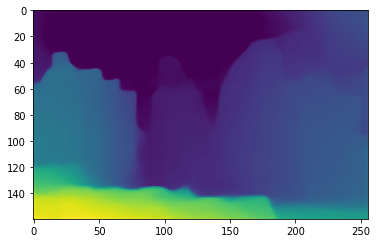

In [98]:
img = cv2.imread("../test_images/inputs/skyscraper_city.jpeg")
print(img.shape)
input_batch = transform(img).to(device)
print('input batch shape ', input_batch.shape)

with torch.no_grad():
        prediction = midas(input_batch)

        # prediction = F.interpolate(
        #     prediction.unsqueeze(1),
        #     mode="bicubic",
        #     align_corners=False
        # ).squeeze()

depth_map = prediction.cpu()
print("shape through midas ", depth_map.shape)
plt.imshow(depth_map.numpy().squeeze())

In [99]:
mp = MaxPool(pool_size=2)
depth_map = depth_map.unsqueeze(0)
print(depth_map.shape)

depth_map = mp.forward(depth_map)
depth_map.shape

torch.Size([1, 1, 160, 256])


torch.Size([1, 1, 80, 128])

(480, 640, 3)
(480, 640, 3)
torch.Size([1, 3, 192, 256])
shape through midas  torch.Size([192, 256])


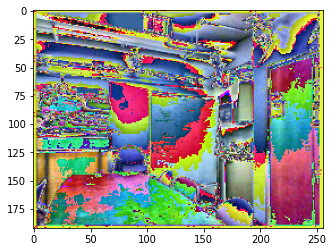

In [16]:
img = cv2.imread('/Users/adityadandwate/Desktop/IIIT-H Internship/dataset/dataset/nyu_depth_v2/official_splits/train/rgb/rgb_00004.jpg')
print(img.shape) #(H, W, C)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)
# plt.imshow(img)
input = transform(img).to(device)
print(input.shape)
# print(input)
plt.imshow(TF.to_pil_image(input.squeeze()))
with torch.no_grad():
    prediction = midas(input)

depth_map = prediction.cpu()
depth_map = depth_map.squeeze()
print('shape through midas ', depth_map.shape)
# plt.imshow(depth_map.numpy())

# input = input.squeeze()
# print(input.shape)

# show_image = input.permute(1, 2, 0).cpu().numpy()
# print(show_image.shape)
# plt.imshow(show_image)

In [87]:
def transform_batch(batch):
    rgb, depth = batch
    transformed_imgs = []
    for img in rgb:
        # print(img)
        # print(img.shape) # (C, H, W)
        img = img.permute(1, 2, 0)*255
        img = img.numpy().astype(np.uint8)
        # img = TF.to_pil_image(img)
        # plt.imshow(img)
        transformed = transform(img).to(device)
        print(transformed.shape)
        transformed = transformed.squeeze()
        # print(transformed.shape) # (C, H, W)
        transformed_imgs.append(transformed)

        # # show_img = transformed.permute(1, 2, 0).cpu()
        # # print(show_img.shape)
        # # plt.imshow(show_img.numpy())
        # print(transformed)
        # show_image = TF.to_pil_image(transformed)
        # plt.imshow(show_image)
        # plt.show()
    transformed_imgs = torch.stack(transformed_imgs, dim=0)
    transformed_imgs = transformed_imgs.to(device)
    return transformed_imgs



torch.Size([1, 3, 192, 256])
torch.Size([1, 3, 192, 256])
torch.Size([1, 3, 192, 256])
torch.Size([1, 3, 192, 256])
torch.Size([1, 3, 192, 256])
torch.Size([1, 3, 192, 256])
torch.Size([1, 3, 192, 256])
torch.Size([1, 3, 192, 256])
shape after trans  torch.Size([8, 3, 192, 256])
torch.Size([8, 3, 480, 640])
torch.Size([3, 192, 256])
torch.Size([1, 3, 192, 256])
shape after midas  torch.Size([1, 192, 256])


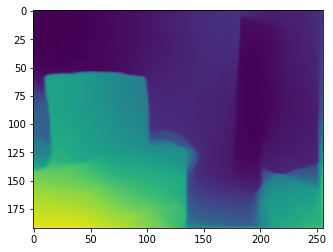

In [88]:
# trans_batch = transform_batch(batch=batch)
# print('rgb shape ', rgb.shape)
trans_batch = transform_batch(batch=batch)
print('shape after trans ', trans_batch.shape)
trans_rgb = trans_batch
with torch.no_grad():
    print(rgb.shape)
    for img_rgb in trans_rgb:
        print(img_rgb.shape)
        img_rgb = img_rgb.unsqueeze(0)
        print(img_rgb.shape)
        prediction = midas(img_rgb)
        print('shape after midas ', prediction.shape)
        show_image = prediction.cpu().squeeze()
        plt.imshow(show_image.numpy())
        break

In [46]:
rgb, depth = batch
print(rgb.shape)
encoded_rgb = encoder.forward(rgb)
print(encoded_rgb.shape)

torch.Size([8, 3, 480, 640])
torch.Size([8, 64, 120, 160])


In [84]:
class Model(nn.Module):

    def __init__(self) -> None:
        super(Model, self).__init__()

        self.encoder = Encoder() # Encoder network 
        self.midas_model = midas # midas network depth estimation
        self.extract_graph = ExtractGraph()
        self.gnn_model = GNNModel(120*160)
        

    def train(self, train_dataloader, num_epochs, lr):

        for epoch in range(num_epochs):
            
            running_loss = 0.0

            for batch in train_dataloader:   
                rgb, true_depth = batch
                trans_rgb = transform_batch(batch)

                depth_maps = self.midas_model(trans_rgb)    # Get depth maps from the pretrained models in a batch with dim 192, 256
                down_rgb = self.encoder.forward(rgb) #returns encoded image with dim 120, 160 which will make up the node features

                target_size = down_rgb.shape[2:]
                num_downsampled_channels = down_rgb.shape[1]
                target_size = [x*2 for x in target_size]                    # Maxpool will downsample by half further

                resize_transform = transforms.Resize(target_size)
                depth_maps = resize_transform(depth_maps) # Downsample midas output to (240, 320) using bilinear interpolation
                depth_maps = depth_maps.unsqueeze(1)
                print('shape of depth maps after interpolation ', depth_maps.shape)

                # adjacency_matrices = []

                # for dmap in depth_maps:
                #     print(dmap.shape)
                #     adj_matrix = self.extract_graph.forward(dmap, 0.4, target_size[0], target_size[1])
                #     adjacency_matrices.append(adj_matrix)
            
                adjacency_matrix = self.extract_graph.forward(depth_maps, 0.4)
                print(adjacency_matrix.shape)

                # node_featues = torch.reshape(down_rgb, (num_downsampled_channels, -1)) #shape will be (64, 120*160)
                # node_featues = node_featues.t() # shape will be (120*160, 64)

                # adj_coo = adjacency_matrix.to_sparse().coalesce()
                # edge_index = adj_coo.indices()

                # output = self.gnn_model.forward(down_rgb, edge_index)
                # output = output.t()

                break


In [85]:
model = Model()
model.train(train_dataloader, 1, 0.0001)

shape of depth maps after interpolation  torch.Size([8, 1, 240, 320])
pooled shape  torch.Size([8, 1, 120, 160])
120 160
torch.Size([19200, 19200])
torch.Size([19200, 19200])


In [102]:
resizer = transforms.Resize([192, 256])

sample = torch.randn((1, 480, 640))
print(sample.shape)

sample = resizer(sample)
print(sample.shape)

torch.Size([1, 480, 640])
torch.Size([1, 192, 256])
